In [27]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.optimizers import RMSprop

In [6]:
dataLink = './Dataset'
Images_path = []
vgg19_mean_subtraction = [103.939, 116.779, 123.68]
batch_size = 32
image_size = 224

In [7]:
# Importing the image paths from the directory and saving in a list

for dirLink, dirName, fileName in os.walk(dataLink):
    
    file_count = 0
    for file in fileName:
        Images_path.append(os.path.join(dirLink, file))
        file_count += 1
    
    print(f"Completed directory: {dirLink} - {file_count} files added")


print(f"Finished collecting all images: {len(Images_path)} total files from {dataLink}")

Completed directory: ./Dataset - 0 files added
Completed directory: ./Dataset\Bio_degradable - 1496 files added
Completed directory: ./Dataset\Non_Bio_degradable - 1496 files added
Finished collecting all images: 2992 total files from ./Dataset


In [8]:
y_values = np.array([0] * len(os.listdir('./Dataset/Bio_degradable')) + [1] * len(os.listdir('./Dataset/Non_Bio_degradable')))
print(f'Number of Y values to Predict is {len(y_values)} aligning with Images {len(Images_path)}')

Number of Y values to Predict is 2992 aligning with Images 2992


In [9]:
indices = np.arange(len(Images_path))
np.random.shuffle(indices)


Images_path = np.array(Images_path)[indices].tolist()
y_values = y_values[indices]

Image Format : JPEG
Image Shape : (200, 200, 3)


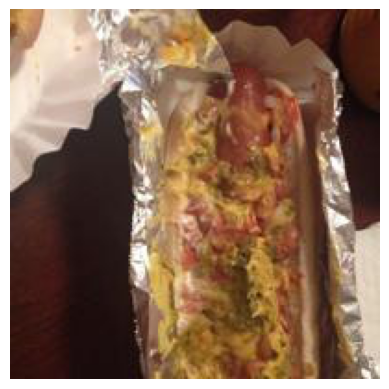

In [10]:
# Observing the Image

path = Images_path[random.randint(0,len(Images_path)-1)]
img = Image.open(path)
print(f'Image Format : {img.format}')
print(f'Image Shape : {np.array(img).shape}')


plt.imshow(img)
plt.axis('off')
plt.show()


In [12]:
# Every Image is in JPG format!! with (224,224,3) specification (Note: PIL treats jpg as jpeg internally).

# TO-DO :   make sure every image is in same shape,
#           shuffle
#           Assuring they are in float32 dtype,
#           data labelling, 
#           splitting
#           data agumentation (Image Data Generator), 
#           converting to bgr, 
#           mean-subtraction, 


In [13]:
unprocessed_images = []
valid_paths = []
valid_y = []
for i, img_file in enumerate(Images_path):
    try:
        img = Image.open(img_file).resize((224, 224), Image.Resampling.LANCZOS)
        unprocessed_images.append(np.array(img, dtype=np.float32))
        valid_paths.append(img_file)
        valid_y.append(y_values[i])
    except Exception as e:
        print(f"Failed to load {img_file}: {e}")
        
        
unprocessed_images = np.array(unprocessed_images)
Images_path = valid_paths
y_values = np.array(valid_y)
print(f'The total of {len(unprocessed_images)} images in {unprocessed_images.shape} format with dtype of {unprocessed_images.dtype}')

The total of 2992 images in (2992, 224, 224, 3) format with dtype of float32


In [14]:
print(f'The total of valid images {len(unprocessed_images)} matches with paths {len(Images_path)} and y values {len(y_values)} ')

The total of valid images 2992 matches with paths 2992 and y values 2992 


In [15]:
X_train, X_temp, y_train, y_temp =  train_test_split(unprocessed_images, y_values, test_size = 0.3, stratify = y_values, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, stratify = y_temp, random_state = 42)


In [16]:
print(f' Training set images has {len(X_train)} samples')
print(f' Training set prediction has {len(y_train)} samples')
print(f' Validation set images has {len(X_val)} samples')
print(f' Validation set predictions has {len(y_val)} samples')
print(f' Test set images has {len(X_test)} samples')
print(f' Test set predictions has {len(X_test)} samples')

 Training set images has 2094 samples
 Training set prediction has 2094 samples
 Validation set images has 449 samples
 Validation set predictions has 449 samples
 Test set images has 449 samples
 Test set predictions has 449 samples


In [17]:
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate up to 20 degrees
    width_shift_range=0.2,   # Shift width by up to 20%
    height_shift_range=0.2,  # Shift height by up to 20%
    horizontal_flip=True,    # Random horizontal flips
    zoom_range=0.2,          # Zoom in/out by up to 20%
    fill_mode='nearest'      # Fill new pixels with nearest value
)

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

In [18]:
print(f'There are total of ceiled {len(train_generator)} batches')

There are total of ceiled 66 batches


In [19]:
def vgg19_preprocessing(images):
    """
    Preprocess images for VGG19: converts RGB to BGR and subtract ImageNet means.
    
    Args:
        x: NumPy array of shape (samples, height, width, 3), float32, 0-255 range.
    
    Returns:
        Preprocessed array in BGR with mean subtraction.
        
    """
    
    bgr_images = images[..., ::-1] # RGB to BGR
    
    imagenet_means = np.array(vgg19_mean_subtraction, dtype=np.float32)
    
    return bgr_images - imagenet_means 

In [20]:
X_val_processed = vgg19_preprocessing(X_val)
X_test_processed = vgg19_preprocessing(X_test)

In [28]:
class CustomDataGenerator(Sequence):
    def __init__(self, generator):
        self.generator = generator
    
    def __len__(self):
        return len(self.generator)
    
    def __getitem__(self, index):
        
        X_batch, y_batch = self.generator[index]
        
        X_batch_processed = vgg19_preprocessing(X_batch)
        
        return X_batch_processed, y_batch

In [29]:
custom_train_generator = CustomDataGenerator(train_generator)

In [23]:
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
vgg.trainable = False

In [30]:
model = Sequential([
                    vgg, 
                    Flatten(), 
                    Dense(128, activation='relu'), 
                    Dropout(0.2),
                    Dense(1, activation='sigmoid')
                    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [31]:
model.fit(
    custom_train_generator,
    steps_per_epoch=len(train_generator),#66
    validation_data=(X_val_processed, y_val),
    epochs=20
)

Epoch 1/20


66/66 [==============================] - 219s 3s/step - loss: 1.4119 - accuracy: 0.9456 - val_loss: 1.0558 - val_accuracy: 0.9354
Epoch 2/20
66/66 [==============================] - 286s 4s/step - loss: 0.2379 - accuracy: 0.9675 - val_loss: 0.1824 - val_accuracy: 0.9777
Epoch 3/20
66/66 [==============================] - 387s 6s/step - loss: 0.1604 - accuracy: 0.9680 - val_loss: 0.1975 - val_accuracy: 0.9688
Epoch 4/20
66/66 [==============================] - 229s 3s/step - loss: 0.1318 - accuracy: 0.9675 - val_loss: 0.2627 - val_accuracy: 0.9666
Epoch 5/20
66/66 [==============================] - 541s 8s/step - loss: 0.1653 - accuracy: 0.9742 - val_loss: 0.3811 - val_accuracy: 0.9710
Epoch 6/20
66/66 [==============================] - 234s 4s/step - loss: 0.0948 - accuracy: 0.9776 - val_loss: 0.1433 - val_accuracy: 0.9733
Epoch 7/20
66/66 [==============================] - 254s 4s/step - loss: 0.0733 - accuracy: 0.9771 - val_loss: 0.1305 - val_accuracy: 0.9621
Epoch 8/20


In [32]:
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

15/15 [==============================] - 47s 3s/step - loss: 0.2345 - accuracy: 0.9800
Test Loss: 0.2345, Test Accuracy: 0.9800


15/15 [==============================] - 41s 3s/step
Validation Precision: 0.9821, Recall: 0.9778, F1-Score: 0.9800


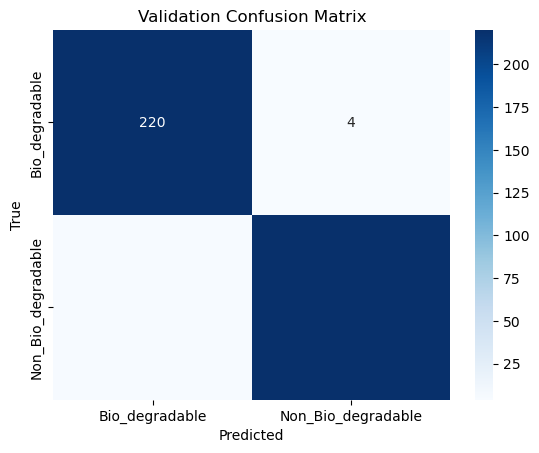

1/1 [==============================] - 0s 189ms/step


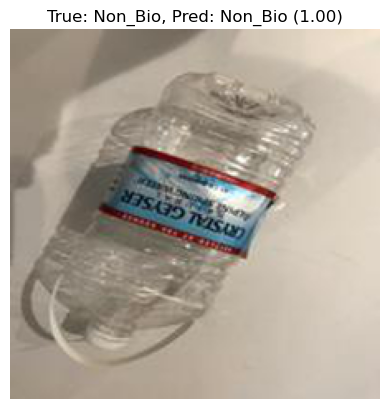

1/1 [==============================] - 0s 182ms/step


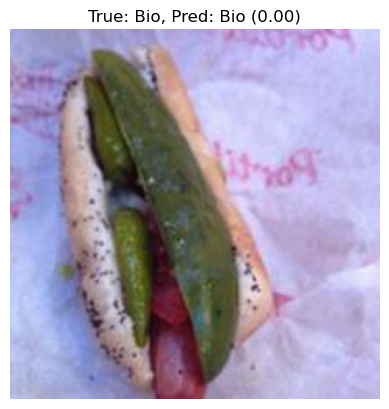

1/1 [==============================] - 0s 215ms/step


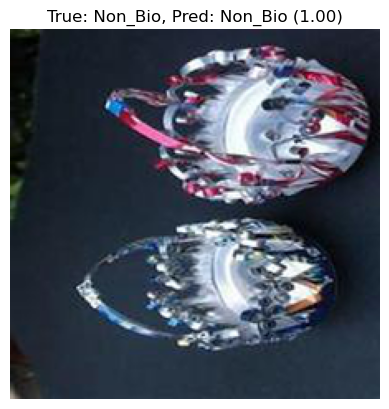

1/1 [==============================] - 0s 222ms/step


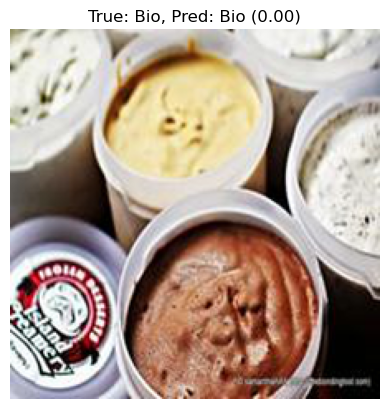

1/1 [==============================] - 0s 166ms/step


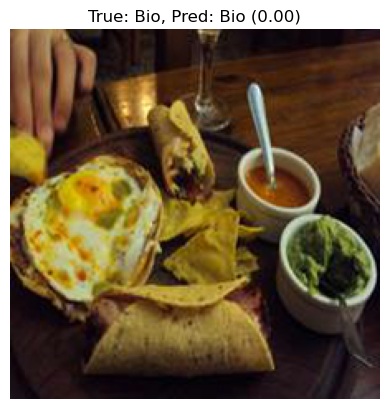

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns


y_val_pred = (model.predict(X_val_processed) > 0.5).astype(int).flatten()


precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
print(f"Validation Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bio_degradable', 'Non_Bio_degradable'], yticklabels=['Bio_degradable', 'Non_Bio_degradable'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()

# Visualize a few validation predictions
indices = random.sample(range(len(X_val_processed)), 5)  # Randomly select 5 validation images
for idx in indices:
    img = X_val_processed[idx] + np.array(vgg19_mean_subtraction)  # Undo mean subtraction
    img = img[..., ::-1]  # BGR to RGB
    img = np.clip(img, 0, 255).astype(np.uint8)

    pred = model.predict(X_val_processed[idx:idx+1])[0][0]
    label = y_val[idx]
    plt.imshow(img)
    plt.title(f"True: {'Bio' if label == 0 else 'Non_Bio'}, Pred: {'Bio' if pred < 0.5 else 'Non_Bio'} ({pred:.2f})")
    plt.axis('off')
    plt.show()

In [34]:
model.save('vgg19_biodegradable_classifier.h5')
print("Model saved as 'vgg19_biodegradable_classifier.h5'")

C:\Users\mohit\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'vgg19_biodegradable_classifier.h5'


15/15 [==============================] - 49s 3s/step
Test Precision: 0.9778, Recall: 0.9821, F1-Score: 0.9800


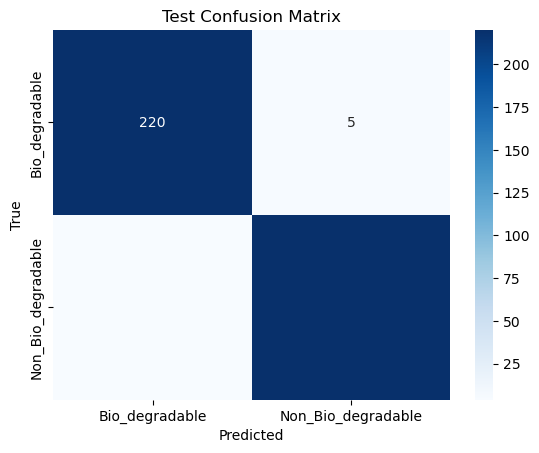

In [35]:
# Test set analysis
y_test_pred = (model.predict(X_test_processed) > 0.5).astype(int).flatten()
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
print(f"Test Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")

cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Bio_degradable', 'Non_Bio_degradable'], yticklabels=['Bio_degradable', 'Non_Bio_degradable'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()